# **Few-Shot Learning for Logical and Structural Detection (SimpleNet)**

## **Download Dataset**

In [1]:
!gdown 1FrMzu3EXPei7EeBql-169DuGK3ws2sJO
!tar -xf mvtec_loco_anomaly_detection.tar.xz

Downloading...
From (original): https://drive.google.com/uc?id=1FrMzu3EXPei7EeBql-169DuGK3ws2sJO
From (redirected): https://drive.google.com/uc?id=1FrMzu3EXPei7EeBql-169DuGK3ws2sJO&confirm=t&uuid=5c60d0ce-454c-4e81-ba23-4db4d54ec590
To: /content/mvtec_loco_anomaly_detection.tar.xz
100% 6.13G/6.13G [01:01<00:00, 99.0MB/s]


## **Import Modules**

In [2]:
! pip install einops

In [3]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from PIL import Image
from einops import rearrange
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

## **Dataset**

In [4]:
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./', anomaly_type=None, class_name='breakfast_box', mode = 'train',
                 few_shot=1, resize=256):
        assert class_name in ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
        self.class_name = class_name
        assert anomaly_type in [None, 'logical', 'structural']
        self.anomaly_type = anomaly_type
        assert mode in ['train', 'validation', 'test']
        self.mode = mode
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot # 1, 2, 4, 8
        # set transforms
        self.transform_x = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize([resize,resize], interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        print(f"{self.class_name} {self.mode} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, self.mode)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            if img_type != 'good' and self.anomaly_type is not None and img_type != self.anomaly_type + '_anomalies':
                    continue
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_dir_list = [os.path.join(gt_type_dir, img_fname) for img_fname in img_fname_list]
                for dir in gt_dir_list:
                    gt_mask = torch.zeros([1, self.resize, self.resize])
                    for f in os.listdir(dir):
                        if f.endswith('.png'):
                            gt_mask = gt_mask + self.transform_mask(Image.open(os.path.join(dir, f)))
                        gt_mask = torch.clip(gt_mask, 0., 1.)
                        mask.append(gt_mask)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and self.mode=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')) for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]) if y==0 else mask for y,mask in zip(list(y),list(mask))]



## **Other Utility Functions**

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def compute_metric(result):
    fpr, tpr, _ = roc_curve(result['total_gt_image'], result['total_scores_image'])
    auc = roc_auc_score(result['total_gt_image'], result['total_scores_image'])
    return fpr, tpr, auc

def plot_roc_curve(fpr, tpr, auc, class_name=''):
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"ROC curve (area = {auc: 0.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_anomaly_map(result, class_name, TestDataset, index, threshold):
    dataset_size = len(TestDataset)
    # Load Testing Input / Ground Truth Mask / Predicted Mask
    input_image = rearrange(result['input_image'][index], 'c h w -> h w c')
    # Denormalize
    input_image[:, : 0] = input_image[:, : 0] * 0.229 + 0.485
    input_image[:, : 1] = input_image[:, : 1] * 0.224 + 0.456
    input_image[:, : 2] = input_image[:, : 2] * 0.225 + 0.406
    input_image = np.clip(input_image, 0., 1.).astype(float)
    gt_mask = rearrange(result['total_gt_pixel'],'b c h w -> (b c) h w')[index]
    predicted_mask = rearrange(result['total_scores_pixel'],'(b c h w) -> (b c) h w',b=dataset_size,c=1,h=256,w=256)[index]
    predicted_mask = np.where(predicted_mask > threshold, 1., 0.)

    fig, ax = plt.subplots(1, 3)
    fig.suptitle(f'{class_name} Dataset', x=0.5, y=0.72)
    ax[0].imshow(input_image)
    ax[0].set_title('Input')
    ax[1].imshow(gt_mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(predicted_mask)
    ax[2].set_title('Predicted')
    plt.tight_layout()
    plt.show()
    return

## **SimpleNet**

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

In [6]:
from torchvision.models import wide_resnet50_2

# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model, img, outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

# produce multi-scale feature
def concat_feature(features, use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = 32 # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        temp_feaure = F.interpolate(features[i], (target_size, target_size), mode="bilinear", align_corners=False)
        #############################################################
        resized_feature.append(temp_feaure)

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

def init_weight(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

# Adaptor
class Adaptor(torch.nn.Module):
    def __init__(self, in_planes, out_planes=None, n_layers=1, layer_type=0):
        super(Adaptor, self).__init__()
        if out_planes is None:
            out_planes = in_planes
        self.layers = torch.nn.Sequential()
        self.in_channel = in_planes
        _in = None
        _out = None
        for i in range(n_layers):
            _in = in_planes if i == 0 else _out
            _out = out_planes
            self.layers.add_module(f"{i}fc", torch.nn.Linear(_in, _out))
            if i < n_layers - 1:
                if layer_type > 0:
                    self.layers.add_module(f"{i}bn", torch.nn.BatchNorm1d(_out))
                if layer_type > 1:
                    self.layers.add_module(f"{i}relu", torch.nn.LeakyReLU(.2))
        self.apply(init_weight)
    def forward(self, x):
        # x = .1 * self.layers(x) + x
        x = rearrange(x,'b c h w -> (b h w) c')
        x = self.layers(x)
        return x

# Discriminator
class Discriminator(torch.nn.Module):
    def __init__(self, in_planes, hidden=[1024]):
        super(Discriminator, self).__init__()
        _hidden = in_planes if hidden is None else hidden[0]
        self.body = torch.nn.Sequential()
        self.in_channel = in_planes
        for i in range(len(hidden)):
            _in = in_planes if i == 0 else hidden[i-1]
            _hidden = int(_hidden // 1.5) if hidden is None else hidden[i]
            self.body.add_module('block%d'%(i+1), torch.nn.Sequential(
                                     torch.nn.Linear(_in, _hidden),
                                     torch.nn.BatchNorm1d(_hidden),
                                     torch.nn.LeakyReLU(0.2)
                                 ))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)
    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x

# SimpleNet
class SimpleNet(nn.Module):
    def __init__(self, config):
        super(SimpleNet,self).__init__()
        self.adaptor = Adaptor(config['in_channel'], config['in_channel'], n_layers=config['Adaptor_n_layers'], layer_type=config['Adaptor_layer_type'])
        self.discriminator = Discriminator(config['in_channel'], hidden=config['Discriminator_hidden'])
        self.noise_K = config['noise_K']
        self.noise_std = config['noise_std']


    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, self.noise_K, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=self.noise_K).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, self.noise_std * 1.1**(k), true_feats.shape)
            for k in range(self.noise_K)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **Train/Validation/Test**

### **Train**

In [7]:
def train(encoder, model, dataset, config):

    # optimizer
    adaptor_optim = torch.optim.AdamW(model.adaptor.parameters(), lr=config['adaptor_lr'])
    discriminator_optim = torch.optim.Adam(model.discriminator.parameters(), lr=config['discriminator_lr'], weight_decay=1e-5)

    # train
    # for epoch in tqdm(range(config['epochs'])):
    for epoch in range(config['epochs']):
        for x,y,mask in DataLoader(dataset, batch_size=config['batch_size']):
            x, y = x.to(config['device']), y.to(config['device'])
            features = get_features(encoder,x,outputs)
            features = concat_feature(features,config['use_layers'])
            scores = model(features)
            true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
            fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

            th = 0.5 #margin
            true_loss = torch.clip(true_scores + th, min=0)
            fake_loss = torch.clip(-fake_scores + th, min=0)

            loss = true_loss.mean() + fake_loss.mean()

            # clear gradient
            adaptor_optim.zero_grad()
            discriminator_optim.zero_grad()

            # calculate new gradient
            loss.backward()

            # update parameters
            adaptor_optim.step()
            discriminator_optim.step()

### **Validaion**

In [8]:
def dev():
    pass

### **Test**

In [9]:
#######################################
# testing
@torch.no_grad()
def test(encoder, simplenet, dataset, config):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=config['batch_size']):
        x, y = x.to(config['device']), y.to(config['device'])
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,config['use_layers'])
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        result['total_gt_pixel'].append(mask.detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.concatenate(result['total_gt_pixel'],axis=0)
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

## **Training/Testing Process**

### **Config**

In [10]:
config = {
    'few_shot' : 8,
    'anomaly_type' : None, # None, 'logical', 'structural'
    'adaptor_lr' : 1e-3,
    'discriminator_lr' : 2e-4,
    'epochs' : 20,
    'batch_size' : 8,
    'device' : device,
    'in_channel' : 1792,
    'use_layers' : [1, 2, 3], # with in_channel {0:1024,1:256,2:512,3:1024}
    'Adaptor_n_layers' : 1,
    'Adaptor_layer_type' : 0,
    'Discriminator_hidden' : [1024, 512],
    'noise_K' : 5,
    'noise_std' : 0.1
}

### Create Datasets

In [11]:
datasets = {}
class_names = ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
modes = ['train', 'validation', 'test']

for class_name in ['breakfast_box']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'])

breakfast_box train dataset created, consists of 8 images
breakfast_box test dataset created, consists of 275 images


### **Training**

In [12]:
model = SimpleNet(config).to(device)
train(encoder, model, datasets['breakfast_box']['train'], config)

### **Testing**

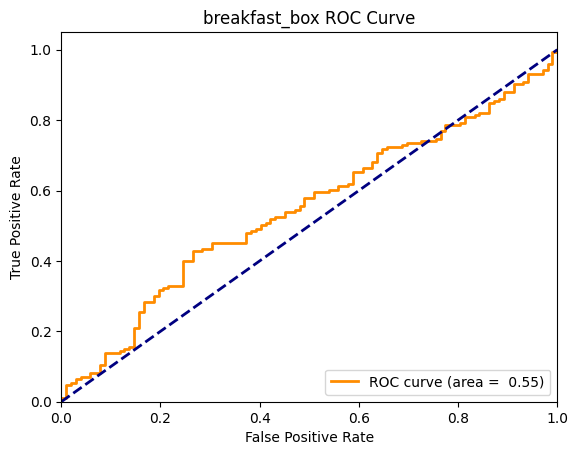

In [13]:
result = test(encoder, model, datasets['breakfast_box']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'breakfast_box')

visualize anomaly map

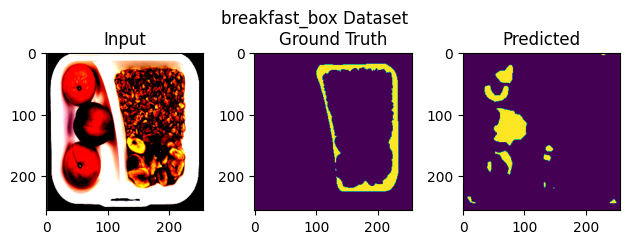

In [40]:
anomaly_threshold = 0.6
# Get a random sample
# index = int(np.random.random()*len(result['input_image']))
index = 150
plot_anomaly_map(result, 'breakfast_box', datasets['breakfast_box']['test'], index, anomaly_threshold)

need to delete model / result in each training process, to avoid the lack of ram

In [ ]:
del model
del result

## Test on multiple Class

In [ ]:
auc_list = []
for class_name in ['breakfast_box', 'juice_bottle', 'pushpins']:
    model = SimpleNet(config).to(device)
    train(encoder, model, datasets['breakfast_box']['train'], config)
    result = test(encoder, model, datasets['breakfast_box']['test'], config)
    fpr, tpr, auc = compute_metric(result)
    auc_list.append(auc)

    del model
    del result
print(np.mean(auc_list))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0.6351203294419888


## Search best noise

In [14]:
best_auc, best_k, best_std = 0, 0, 0

for noise_k in [1, 3, 5]:
    for noise_std in [0.01, 0.05, 0.1, 0.5, 1]:
        auc_list = []
        for class_name in tqdm(['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']):
            config['noise_K'] = noise_k
            config['noise_std'] = noise_std
            model = SimpleNet(config).to(device)
            train(encoder, model, datasets[class_name]['train'], config)
            result = test(encoder, model, datasets[class_name]['test'], config)
            fpr, tpr, auc = compute_metric(result)
            auc_list.append(auc)

            del model
            del result

        if np.mean(auc_list) > best_auc:
            best_k = noise_k
            best_std = noise_std
            best_auc = np.mean(auc_list)

print(best_k, best_std, best_auc)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

5 0.1 0.5765272518375941
